In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense,Input,Dropout,Flatten,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Reshape, SimpleRNN
from tensorflow.keras.layers import LSTM

In [22]:
path = '/Users/mohammadmujahidnadeem/Downloads/New/images'

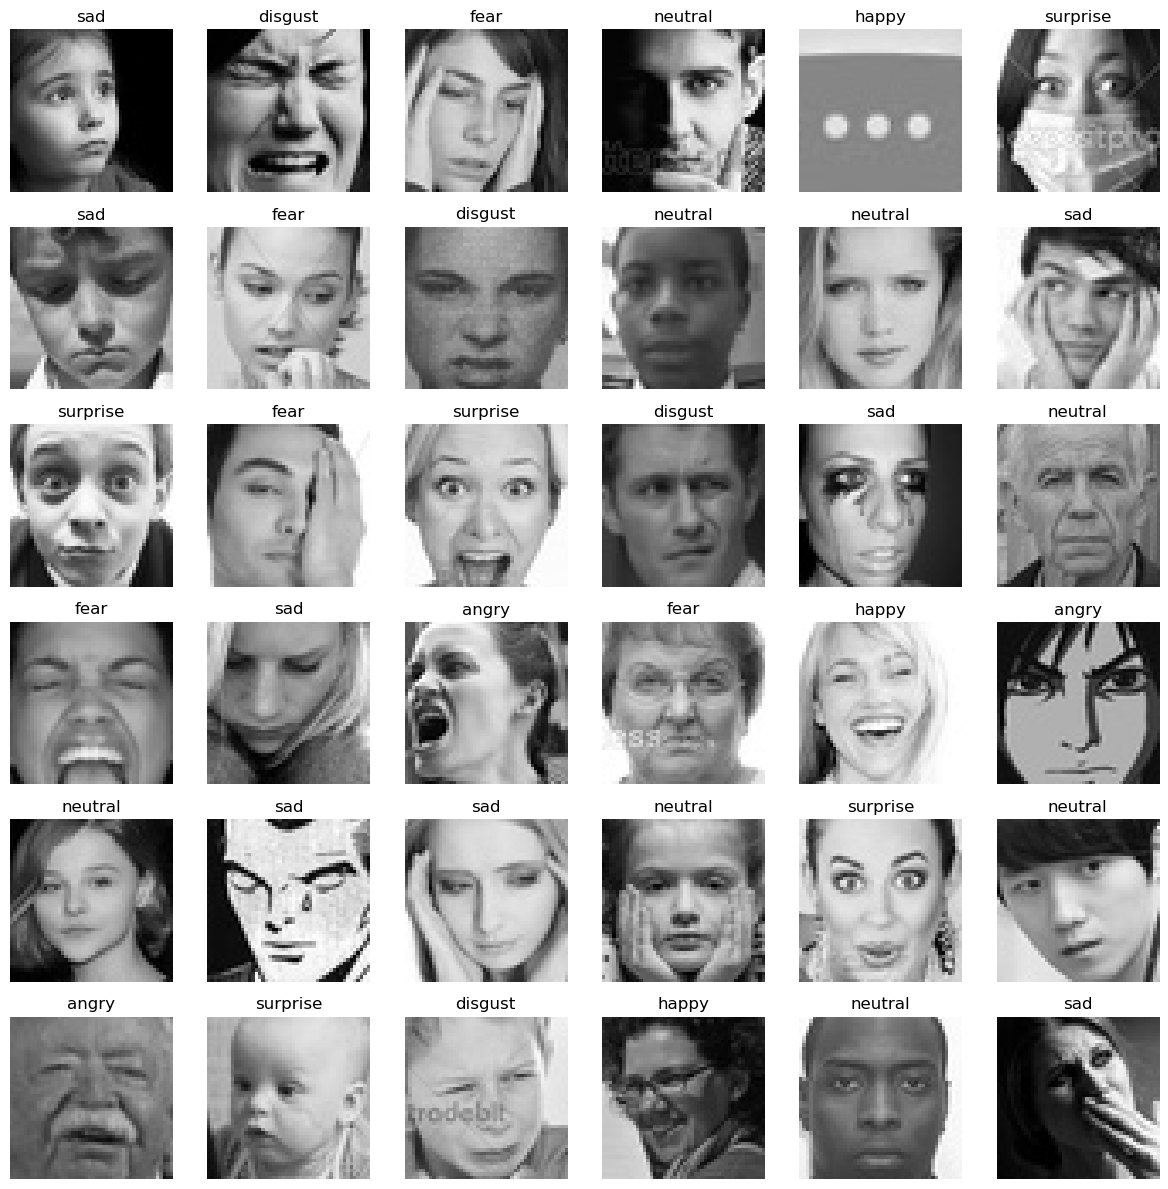

In [23]:
import random
expressions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
random.shuffle(expressions)
plt.figure(figsize=(12, 12))
index = 1

for i in range(1,37):
    expression = random.choice(expressions)
    image_path = os.path.join(path, 'train', expression)
    image_files = os.listdir(image_path)
    random.shuffle(image_files)
    image = load_img(os.path.join(image_path, image_files[i]), target_size=(48, 48))
    plt.subplot(6, 6, index)
    plt.imshow(image)
    plt.title(expression)
    plt.axis('off')
    index += 1

plt.tight_layout()
plt.show()

In [24]:
batch_size = 128
train_datagenerator = ImageDataGenerator()
validation_datagenerator = ImageDataGenerator()
trainpath = '/Users/mohammadmujahidnadeem/Downloads/New/images/train'
validpath = '/Users/mohammadmujahidnadeem/Downloads/New/images/validation'
train_set = train_datagenerator.flow_from_directory(trainpath,
                                                   target_size=(48, 48), 
                                                   color_mode="grayscale",
                                                   class_mode="categorical", 
                                                   batch_size=batch_size, 
                                                   shuffle=True)
test_set = validation_datagenerator.flow_from_directory(validpath,
                                                       target_size=(48, 48), 
                                                       color_mode="grayscale",
                                                       class_mode="categorical", 
                                                       batch_size=batch_size, 
                                                       shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [25]:

batch_size = 128
train_datagenerator = ImageDataGenerator()
validation_datagenerator = ImageDataGenerator()
trainpath = '/Users/mohammadmujahidnadeem/Downloads/New/images/train'
validpath = '/Users/mohammadmujahidnadeem/Downloads/New/images/validation'
train_set = train_datagenerator.flow_from_directory(trainpath,
                                                   target_size=(48, 48), 
                                                   color_mode="grayscale",
                                                   class_mode="categorical", 
                                                   batch_size=batch_size, 
                                                   shuffle=True)
test_set = validation_datagenerator.flow_from_directory(validpath,
                                                       target_size=(48, 48), 
                                                       color_mode="grayscale",
                                                       class_mode="categorical", 
                                                       batch_size=batch_size, 
                                                       shuffle=False)

classes = 7
model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3,3), padding="same", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (5,5), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(512, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4th CNN layer
model.add(Conv2D(512, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Reshape for RNN or LSTM
model.add(Reshape((9, 512)))  # Adjust based on the actual output shape

# Add RNN or LSTM layer
model.add(SimpleRNN(64, return_sequences=True))  # RNN layer with return_sequences
model.add(LSTM(64))                              # LSTM layer

# Flatten before fully connected layers
model.add(Flatten())

# 1st connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2nd connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(classes, activation='softmax'))

# Use the legacy Adam optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                   

In [26]:
model_checkpoint = ModelCheckpoint("./model.h5",
                                   monitor="val_accuracy",
                                   verbose=1,
                                   save_best_only=True,
                                   mode="max")

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

callbacks_list = [early_stop, model_checkpoint, reduce_learning_rate]
epochs = 5  # Increase the number of epochs for better training


In [27]:
history = model.fit(
    train_set,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=test_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    validation_steps=test_set.n // test_set.batch_size
)

# Save the model in native Keras format
model.save("./emotion_detection_model.keras")

# If you still need an HDF5 file, you can use the following:
# model.save("./emotion_detection_model.h5", save_format="h5")


Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 2.0200 - accuracy: 0.2095
Epoch 1: val_accuracy improved from -inf to 0.24347, saving model to ./model.h5
225/225 [==============================] - 170s 750ms/step - loss: 2.0200 - accuracy: 0.2095 - val_loss: 1.8012 - val_accuracy: 0.2435 - lr: 1.0000e-04
Epoch 2/5
225/225 [==============================] - ETA: 0s - loss: 1.8865 - accuracy: 0.2599
Epoch 2: val_accuracy improved from 0.24347 to 0.29744, saving model to ./model.h5
225/225 [==============================] - 166s 739ms/step - loss: 1.8865 - accuracy: 0.2599 - val_loss: 1.7767 - val_accuracy: 0.2974 - lr: 1.0000e-04
Epoch 3/5
225/225 [==============================] - ETA: 0s - loss: 1.7754 - accuracy: 0.3117
Epoch 3: val_accuracy improved from 0.29744 to 0.32699, saving model to ./model.h5
225/225 [==============================] - 167s 741ms/step - loss: 1.7754 - accuracy: 0.3117 - val_loss: 1.7157 - val_accuracy: 0.3270 - lr: 1.0000e-04
Epoch 4/5
225

1/1 [==============================] - 0s 186ms/step


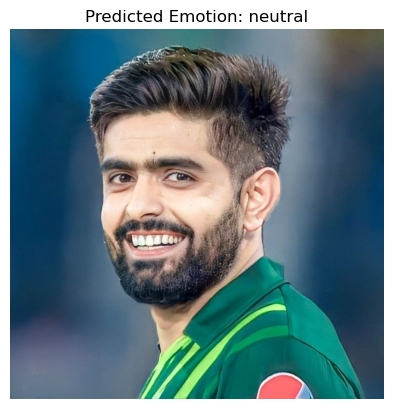

1/1 [==============================] - 0s 12ms/step


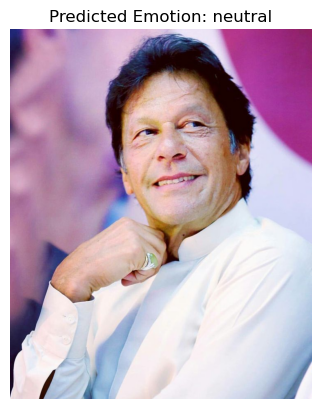

1/1 [==============================] - 0s 13ms/step


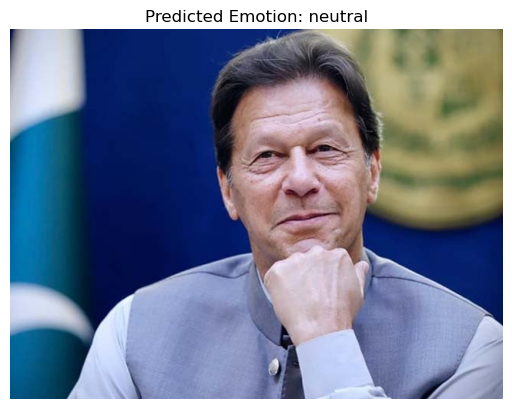

In [43]:
def detect_emotion(image_paths, model_path):
    # Load the trained model
    trained_model = load_model(model_path)

    for image_path in image_paths:
        # Load and preprocess the input image
        img = image.load_img(image_path, target_size=(48, 48), color_mode="grayscale")
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Make prediction
        emotion_probabilities = trained_model.predict(img_array)
        emotion_index = np.argmax(emotion_probabilities)

        # Map the index to the corresponding emotion
        emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        predicted_emotion = emotions[emotion_index]

        # Display the input image with predicted emotion
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f'Predicted Emotion: {predicted_emotion}')
        plt.axis('off')
        plt.show()

# Example usage:
image_paths_to_predict = ['/Users/mohammadmujahidnadeem/Downloads/New/babar.jpg',
                          '/Users/mohammadmujahidnadeem/Downloads/New/immi.jpg',
                          '/Users/mohammadmujahidnadeem/Downloads/New/imran.jpg']
model_path = './emotion_detection_model.keras'
detect_emotion(image_paths_to_predict, model_path)
